In [1]:
%%capture
%pip install --upgrade numpy
%pip install --upgrade scipy

In [2]:
# Импорт библиотек
import math
import numpy as np
import pandas as pd
import scipy # Проверить версию библиотеки при импорте!
import scipy.stats as stats
from scipy.stats import wilcoxon, mannwhitneyu,f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import norm
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest
import statsmodels.stats.api as sms
from typing import List, Tuple, Dict, Set
import matplotlib.pyplot as plt 
import seaborn as sns
import pylab
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# A/B калькулятор https://www.evanmiller.org/ab-testing/chi-squared.html

In [4]:
# Создаем данные
# x1 = np.random.normal(0, 1.5, 100)
# y1 = np.random.normal(0, 1.5, 100)
x1 = [64.2, 28.4, 85.3, 83.1, 13.4, 56.8, 44.2, 90, 86, 75]
y1 = [45, 29.5, 32.3, 49.3, 18.3, 34.2, 43.9, 13.8, 27.4, 43.4]

# Тест, отличается ли среднее выборки от N

In [5]:
N=10
stats.ttest_1samp(x1, N)

Ttest_1sampResult(statistic=6.265559754169641, pvalue=0.00014688203506718392)

# Доверительный интервал для среднего

In [6]:
np.mean(x1)

62.64

In [7]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [8]:
mean_confidence_interval(x1)

(62.64, 43.63452280102512, 81.64547719897487)

In [9]:
def mean_confidence_interval_(data, confidence=0.95):
    return stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=stats.sem(data))

In [10]:
mean_confidence_interval_(x1)

(43.63452280102512, 81.64547719897487)

# Z тест

In [11]:
z,z_pval = ztest(x1, y1, value=0,alternative='two-sided')
print(z,z_pval)

3.145198441422933 0.001659742067075731


# t-тест двух независимых выборок

### Проверка на нормальность данных. Тест Шапиро-Уилка

In [12]:
# Тест Шапиро-Уилка
stat, p = stats.shapiro(x1)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.894, p-value=0.189
Принять гипотезу о нормальности


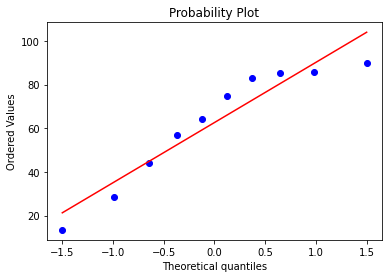

In [13]:
# Графический метод
stats.probplot(x1, dist="norm", plot=pylab)
pylab.show()

### Проверка равенства дисперсий. Критерий Бартлетта

Цитата из Википедии: "Критерий Бартлетта (англ. Bartlett's test) — статистический критерий, позволяющий проверять равенство дисперсий нескольких (двух и более) выборок. Нулевая гипотеза предполагает, что рассматриваемые выборки получены из генеральных совокупностей, обладающих одинаковыми дисперсиями.

Критерий Бартлетта является параметрическим и основан на дополнительном предположении о нормальности выборок данных. Поэтому перед применением критерия Бартлетта рекомендуется выполнить проверку нормальности. Критерий Бартлетта очень чувствителен к нарушению данного предположения.

Плюсы:

объёмы выборок могут быть различными (это его преимущество перед критерием Кохрена), критерий Бартлетта выявляет отклонения, как в наибольшую, так и в наименьшую стороны; Минусы:

сложность вычислений (критерий Кохрена требует меньше вычислительных затрат. Особо это актуально в случае вычислений «вручную»), объём каждой выборки должен быть больше трёх, критерий очень чувствителен к нарушению предположения о нормальности закона распределения исходных данных."

In [14]:
x1_ = np.random.normal(0, 1.5, 100)
x2_ = np.random.normal(0, 1.5, 100)

In [15]:
# Расчет дисперсий
var1 = np.var(x1_)
var2 = np.var(x2_)
print(var1, var2)

2.290683247422461 2.264879243316873


In [16]:
# Критерий Бартлетта
stat, p = stats.bartlett(x1_,x2_)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о равенстве дисперсий')
else:
    print('Отклонить гипотезу о равенстве дисперсий')

Statistics=0.003, p-value=0.955
Принять гипотезу о равенстве дисперсий


###  Проверка гипотезы. t-критерий Стьюдента

t-критерий Стьюдента – общее название для класса методов статистической проверки гипотез (статистических критериев), основанных на распределении Стьюдента. Наиболее частые случаи применения t-критерия связаны с проверкой равенства средних значений в двух выборках.
Для применения t-критерия Стьюдента необходимо, чтобы исходные данные имели нормальное распределение. Также имеет значение равенство дисперсий (распределения) сравниваемых групп (гомоскедастичность). При неравных дисперсиях применяется t-критерий в модификации Уэлча (Welch's t).

t-критерий «боится» выбросов, т.е. аномальных отклонений. Выбросы в данных сильно искажают распределение t-критерия, что, в свою очередь, может привести к ошибкам статистического вывода, поэтому от аномальных наблюдений следует избавиться. Часто из выборки удаляют все значения, выходящие за пределы ±2 стандартных отклонения от средней.

При отсутствии нормального распределения сравниваемых выборок вместо t-критерия Стьюдента используются аналогичные методы непараметрической статистики, среди которых наиболее известными является U-критерий Манна — Уитни.

In [17]:
# H0 - между выборками нет статистически значимых различий
# H1 - между выборками есть статистически значимые различия
stats.ttest_ind(x1, y1,alternative='two-sided')

Ttest_indResult(statistic=3.145198441422933, pvalue=0.005596956346997708)

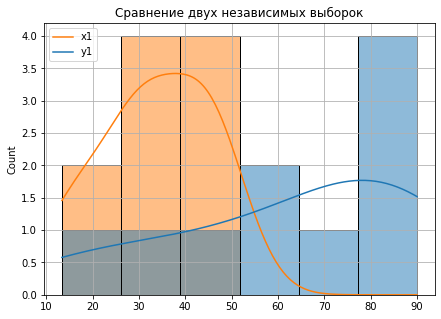

In [18]:
plt.figure(figsize=(7, 5))
df1 = pd.DataFrame({'x1':x1,'y2':y1})
sns.histplot(data=df1, kde=True)
plt.title('Сравнение двух независимых выборок')
plt.legend(['x1', 'y1'])
plt.grid()

### Доверительный интервал разности средних для двух независимых выборок

In [19]:
def mean_diff_confint_ind(sample1,sample2):
    cm = CompareMeans(DescrStatsW(sample1), DescrStatsW(sample2))
    return cm.tconfint_diff(usevar='unequal')

In [20]:
# Построим 95% доверительный интервал для разности средних. Данный интервал не содержит ноль - значит разницу можно признать отличной от нуля.
mean_diff_confint_ind(x1,y1)

(8.967258335059267, 48.89274166494074)

# t-тест двух зависимых выборок

In [21]:
# Создаем данные
x2 = np.random.normal(0, 1.5, 100)
y2 = np.random.normal(1, 1.5, 100)

### Проверка на нормальность данных

In [22]:
# Критерий Пирсона
stat, p = stats.normaltest(x2)
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=1.243, p-value=0.537
Принять гипотезу о нормальности


### Проверка гипотезы

In [23]:
# H0 - между выборками нет статистически значимых различий
# H1 - между выборками есть статистически значимые различия
stats.ttest_rel(x2, y2,alternative='two-sided')

Ttest_relResult(statistic=-5.5201525301225525, pvalue=2.725053907340977e-07)

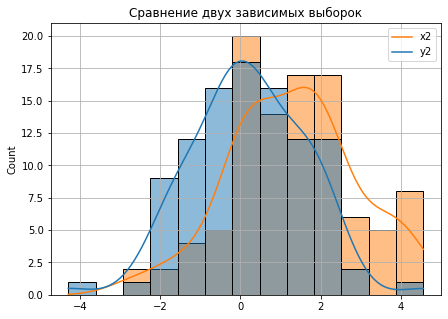

In [24]:
plt.figure(figsize=(7, 5))
df2 = pd.DataFrame({'x2':x2,'y2':y2})
sns.histplot(data=df2, kde=True)
plt.title('Сравнение двух зависимых выборок')
plt.legend(['x2', 'y2'])
plt.grid()

# t-критерий Уэлча

t-критерий Уэлча — тест, основанный на распределении Стьюдента и предназначенный для проверки статистической гипотезы о равенстве математических ожиданий случайных величин, имеющих необязательно равные известные дисперсии. Является модификацией t-критерия Стьюдента. Назван в честь британского статистика Бернарда Льюиса Уэлча.

In [25]:
#equal_var:  указывает на предположение об одинаковой дисперсии между двумя массивами
stats.ttest_ind(x1, y1,equal_var=False)

Ttest_indResult(statistic=3.145198441422933, pvalue=0.008121457311362348)

# Непараметрические критерии

### U-критерий Манна — Уитни

In [26]:
#  Статистический критерий, используемый для оценки различий между двумя независимыми выборками по уровню какого-либо признака, 
# измеренного количественно. Позволяет выявлять различия в значении параметра между малыми выборками.

In [27]:
np.random.seed(11)
A = stats.norm.rvs(scale=30,loc=11,size=100)
B = A + stats.norm.rvs(scale=54,loc=11,size=100)

In [28]:
# H0 - различий нет
# H1 - различия есть
stat, p = mannwhitneyu(A, B,alternative='two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Различий в эффекте нет')
else:
    print('Различия в эффекте есть')

Statistics=4343.000, p=0.109
Различий в эффекте нет


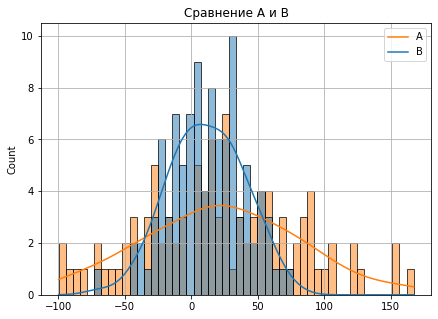

In [29]:
plt.figure(figsize=(7, 5))
df = pd.DataFrame({'A':A, 'B':B})
sns.histplot(data=df, kde=True, bins=50)
plt.title('Сравнение A и B')
plt.legend(['A', 'B'])
plt.grid()

### Т-критерий Вилкоксона

In [30]:
# Также используются названия Т-критерий Уилкоксона, критерий Вилкоксона, критерий знаковых рангов Уилкоксона, критерий суммы рангов Уилкоксона.
# Непараметрический статистический тест (критерий), используемый для проверки различий между двумя выборками парных или независимых измерений по уровню
# какого-либо количественного признака, измеренного в непрерывной или в порядковой шкале. Впервые предложен Фрэнком Уилкоксоном. 
# Другие названия — W-критерий Вилкоксона, критерий знаковых рангов Вилкоксона, критерий Уилкоксона для связных выборок. 
# Тест Вилкоксона для независимых выборок также называется критерием Манна-Уитни.

In [31]:
np.random.seed(11)
C = stats.norm.rvs(scale=30,loc=11,size=100)
D = C + stats.norm.rvs(scale=54,loc=11,size=100)

In [32]:
# H0 - различий нет
# H1 - различия есть
stat, p = wilcoxon(C,D,alternative='two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Различий в эффекте нет')
else:
    print('Различия в эффекте есть')

Statistics=1930.000, p=0.041
Различия в эффекте есть


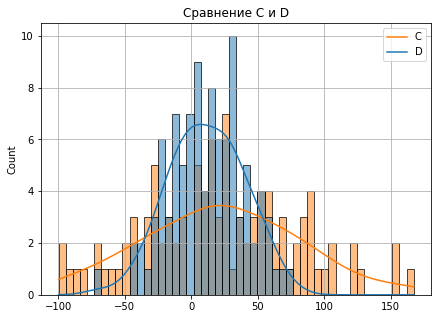

In [33]:
plt.figure(figsize=(7, 5))
df = pd.DataFrame({'C':C, 'D':D})
sns.histplot(data=df, kde=True, bins=50)
plt.title('Сравнение C и D')
plt.legend(['C', 'D'])
plt.grid()

###  Бутстреп

In [34]:
group1 = np.array([1,2,3,4,5,6,7,8,9,10])
group2 = np.array([10,11,12,13,14,15])

In [35]:
def get_bootstrap_samples(data, n_samples):
    """Бутстрап-выборка"""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [36]:
def stat_intervals(stat, alpha=0.05):
    """Доверительный интервал"""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [37]:
group1_median = list(map(np.median, get_bootstrap_samples(group1, 1000)))
group2_median  = list(map(np.median, get_bootstrap_samples(group2, 1000)))

In [38]:
delta_median = list(map(lambda x: x[1] - x[0], zip(group1_median, group2_median)))

In [39]:
print ("Макc значение для для группы1:", np.max(group1),"Мин значение для для группы1:", np.min(group1))
print ("Макc значение для для группы2:", np.max(group2),"Мин значение для для группы2:", np.min(group2))
print ("95% доверительный интервал для группы1:", stat_intervals(group1_median, 0.05))
print ("95% доверительный интервал для группы2:",  stat_intervals(group2_median, 0.05))
print ("95% доверительный интервал для разности медиан:",  stat_intervals(delta_median, 0.05))

Макc значение для для группы1: 10 Мин значение для для группы1: 1
Макc значение для для группы2: 15 Мин значение для для группы2: 10
95% доверительный интервал для группы1: [3. 8.]
95% доверительный интервал для группы2: [10.5 14.5]
95% доверительный интервал для разности медиан: [ 3.5 10. ]


# Корреляция

### Коэффициент корреляции Пирсона

In [40]:
data = {'x1':[2,3,4,15,18],
        'x2':[0,-21,0,-30,12],
        'x3':[2,3,4,5,6],
        'y1':[0.2,0.3,0.4,0.5,0.6],
        'y2':[11.0,-30.2,12.0,-42.5,43.0]}

In [41]:
df = pd.DataFrame(data)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5 non-null      int64  
 1   x2      5 non-null      int64  
 2   x3      5 non-null      int64  
 3   y1      5 non-null      float64
 4   y2      5 non-null      float64
dtypes: float64(2), int64(3)
memory usage: 328.0 bytes


,x1,x2,x3,y1,y2
0,2,0,2,0.2,11.0
1,3,-21,3,0.3,-30.2
2,4,0,4,0.4,12.0
3,15,-30,5,0.5,-42.5
4,18,12,6,0.6,43.0


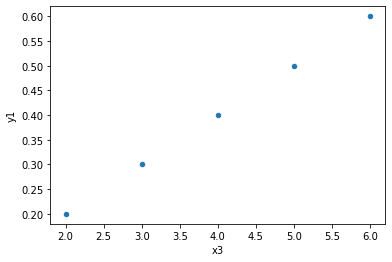

In [42]:
df.plot(kind='scatter', x='x3', y='y1')

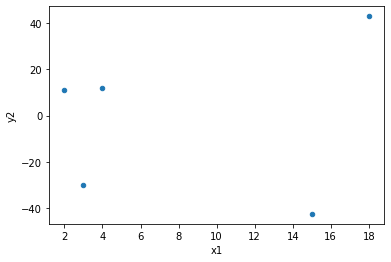

In [43]:
df.plot(kind='scatter', x='x1', y='y2')

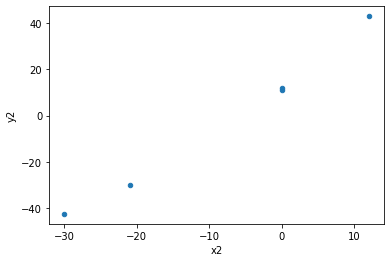

In [44]:
df.plot(kind='scatter', x='x2', y='y2')

In [45]:
# Коэффициент корреляции Пирсона (r-Пирсона) применяется для исследования взаимосвязи двух переменных, измеренных в метрических шкалах на одной и той же выборке. 
# Он позволяет определить, насколько пропорциональная изменчивость двух переменных.
df[['x2', 'y2']].corr()

,x2,y2
x2,1.000000,0.994319
y2,0.994319,1.000000


### Коэффициент ранговой корреляции Спирмена

In [46]:
# Непараметрический метод, который используется с целью статистического изучения связи между явлениями. 
# В этом случае определяется фактическая степень параллелизма между двумя количественными рядами изучаемых признаков и дается оценка тесноты установленной связи с помощью количественно выраженного коэффициента.
df[['x2', 'y2']].corr(method='spearman')

,x2,y2
x2,1.000000,0.974679
y2,0.974679,1.000000


#Дисперсионный анализ

### ANOVA

In [47]:
H = [1, 2, 3, 4, 2, 4, 2, 4, 5, 2, 3, 4, 2, 1, 3, 4, 3, 2, 5, 1]
I= [1, 2, 4, 6, 5, 6, 7, 5, 4, 5, 6, 7, 4, 3, 5, 5, 6, 5, 4, 3, 5]
J = [2, 1, 1, 3, 2, 4, 2, 4, 5, 4, 3, 2, 3, 2, 3, 1, 3, 4, 5, 1, 4]

In [48]:
# H0 - различий нет
# H1 - различия есть
F, p = f_oneway(H, I,J)
print('F=%.3f, p=%.5f' % (F, p))
alpha = 0.05
if p > alpha:
    print('Различий в эффекте нет')
else:
    print('Различия в эффекте есть')

F=12.526, p=0.00003
Различия в эффекте есть


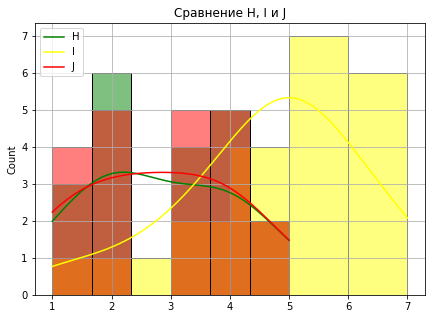

In [49]:
plt.figure(figsize=(7, 5))
sns.histplot(H, kde=True, color='green')
sns.histplot(I, kde=True, color='yellow')
sns.histplot(J, kde=True, color='red')
plt.title('Сравнение H, I и J')
plt.legend(['H', 'I', 'J'])
plt.grid()

# Пропорции

### Тест разности двух независимых долей. Вариант 1

In [50]:
# Реклама "А" получает 3252 откликов на 3730 просмотров, реклама "В" 3872 на 3968
clicks = [290, 430] #отклики в каждой группе
views  = [300, 450] #просмотры в каждой группе

In [51]:
# Расчет конверсии
p1 = clicks[0]/views[0]
p2 = clicks[1]/views[1]

In [52]:
def confidence_interval(conversion:float, trials:int) -> List[float]:
  '''Функция для нахождения доверительного интервала'''
  sigma = math.sqrt(conversion *(1-conversion )/ trials)
  mu = conversion
  probability = 0.95
  interval = stats.norm.interval(probability, loc=mu, scale=sigma)
  interval_round = [round(_*100, 1) for _ in interval]
  return interval_round

In [53]:
# Расчет z метрики. Вариант 1
p_combined = (clicks[0] + clicks[1]) / (views[0] + views[1])
difference = p1 - p2
z_scores = difference /math.sqrt(p_combined * (1 - p_combined) * (1/views[0] + 1/views[1]))

In [54]:
print(f"Значение z равно {z_scores}")

Значение z равно 0.7607257743127277


In [55]:
# Расчет z метрики. Вариант 2
def proportions_diff_z_stat_ind(clicks1, views1, clicks2, views2, alpha = 0.05):
  p1 = clicks1/views1
  p2 = clicks2/views2
  p = float(p1*views1 + p2*views2) / (views1 + views2)
  return (p1 - p2) / np.sqrt(p * (1 - p) * (1 / views1 + 1 / views2))

In [56]:
print(f"Значение z равно {proportions_diff_z_stat_ind(290,300,430,450)}")

Значение z равно 0.7607257743127277


In [57]:
print(f"Конверсия вариант А равна {round(p1*100,1)}% \
        Доверительный интервал {confidence_interval(p1, views[0])[0]}% - {confidence_interval(p1, views[0])[1]}%")
print(f"Конверсия вариант В равна {round(p2*100,1)}% \
        Доверительный интервал {confidence_interval(p2, views[1])[0]}% - {confidence_interval(p2, views[1])[1]}%")

Конверсия вариант А равна 96.7%         Доверительный интервал 94.6% - 98.7%
Конверсия вариант В равна 95.6%         Доверительный интервал 93.7% - 97.5%


In [58]:
# Рассчитываем p-value. Вариант 1
p_value = (1 - scipy.stats.norm.cdf(abs(z_scores))) * 2
print('p-значение: {:f}'.format(p_value))

p-значение: 0.446821


In [59]:
# Рассчитываем p-value. Вариант 2
def p_value_val(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")   
    if alternative == 'two-sided':
        return 2 * (1 - norm.cdf(np.abs(z_stat)))   
    if alternative == 'less':
        return norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - norm.cdf(z_stat)

In [60]:
print('p-значение: {:f}'.format(p_value_val(z_scores)))

p-значение: 0.446821


In [61]:
alpha = .05
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Тест разности двух независимых долей. Вариант 2

In [62]:
count = np.array([290, 430])
nobs = np.array([300, 450])
stat, pval = proportions_ztest(count, nobs, alternative = 'two-sided')
print('{0:0.6}'.format(pval))

0.446821


### Коэффициента корреляции Мэтьюса

In [63]:
# Среди респондентов General Social Survey 2014 года хотя бы раз в месяц проводят вечер в баре 203 женщины и 239 мужчин;
# реже, чем раз в месяц, это делают 718 женщин и 515 мужчин.
# Посчитайте значение коэффициента корреляции Мэтьюса между полом и частотой похода в бары.

In [64]:
def Matthews_correlation(a, b, c, d):
    return (a*d-b*c)/np.sqrt((a+b)*(a+c)*(b+d)*(c+d))

In [65]:
men_visit_monthly = 239
women_visit_monthly = 203
men_visit_rarely = 515
women_visit_rarely = 718
print ("Коэффициента корреляции Мэтьюса: %.3f" % np.round(Matthews_correlation(men_visit_monthly, men_visit_rarely, 
                                                                       women_visit_monthly, women_visit_rarely), 3))

Коэффициента корреляции Мэтьюса: 0.109


### Доверительный интервал для разности двух незавимых долей

In [66]:
# В предыдущей задаче давайте попробуем ответить на немного другой вопрос: отличаются ли доля мужчин и доля женщин, относительно часто проводящих вечера в баре?
# Постройте 95% доверительный интервал для разности долей, вычитая долю женщин из доли мужчин.
# Чему равна его нижняя граница? Округлите до четырёх знаков после десятичной точки.

In [67]:
def proportions_confint_diff_ind(p1, count1, p2, count2, alpha = 0.05):    
    z = norm.ppf(1 - alpha / 2.)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    
    return (left_boundary, right_boundary)

In [68]:
all_men = men_visit_monthly + men_visit_rarely
all_women = women_visit_monthly + women_visit_rarely
men_proportion = float(men_visit_monthly)/float(all_men)
women_proportion = float(women_visit_monthly)/float(all_women)
conf_interval_diff = proportions_confint_diff_ind(men_proportion, all_men, women_proportion, all_women)
print ("Доверительный интервал: [%.4f, %.4f]" % (np.round(conf_interval_diff[0],4),np.round(conf_interval_diff[1],4)))

Доверительный интервал: [0.0539, 0.1392]


### Тест Хи-квадрат

In [69]:
# В предыдущей задаче проверьте, значимо ли коэффициент корреляции Мэтьюса отличается от нуля.
# Посчитайте достигаемый уровень значимости; используйте функцию scipy.stats.chi2_contingency.

In [70]:
# chi2 : Статистика теста
# p :  p-value теста
# dof : Степени свободы
# expected : Ожидаемые частоты, основанные на предельных суммах таблицы
chi2, p, do, expected = chi2_contingency([[men_visit_monthly, men_visit_rarely], [women_visit_monthly, women_visit_rarely]])
print ("Хи-квадрат: %f" % chi2)
print ("p-value: %f" % p)

Хи-квадрат: 19.407531
p-value: 0.000011


### Тест Фишера

In [71]:
df3 = pd.DataFrame([[10,15],[39,34]], index=['Рост','Снижение'], columns=['Прогноз','Факт'])
print(df3)

          Прогноз  Факт
Рост           10    15
Снижение       39    34


In [72]:
# H0 - эффект случайный
# H1 - эффект не случайный
oddsratio, pvalue = stats.stats.fisher_exact(df3)
print(pvalue)

0.35417955365927367


#Прочее

### Z-оценка

In [73]:
list_number = [7,8,8,9,10]
# Рассчитываем среднее
mean = np.mean(list_number)
print(mean)
# Рассчитываем дисперсию
var = np.var(list_number,ddof=1)
print(var)
# Рассчитываем стандартное отклонение
std = round(np.std(list_number,ddof=1),2)
print(std)
# Рассчитаем z-оценку для 7.5
z = (7-mean)/std
print(z)

8.4
1.2999999999999998
1.14
-1.228070175438597
